In [23]:
import numpy as np
import csv
import igl
import math
import ripleyK as rk
import ripleyKmito as rkt
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from scipy.io import loadmat 
import os
import plotly.graph_objects as go

In [24]:
def readmitodata(fname):
    """
    Expect a filename of the form "mito_data???.mat" 
    where ??? is the mito number (left padded by 0 is necessary).
    
    argument:
    fname -- string, filename of the mito data
    
    returns:
    mito_dict -- dictionary, keys are the names of the variables in the matlab file
    The keys are:
    'mito' -- the mitochondrion binary shaoe (np.ndarray, has been padded with zeros)
    'vertices' -- the vertices of the meshed mitochondrion (np.ndarray)  
    'faces' -- the faces of the meshed mitochondrion (np.ndarray)
    'cristae_junctions' -- the vertices of the cristae junctions (np.ndarray) or empty list if none
    'min_coords' -- the minimum coordinates of the mitochondrion (np.ndarray) in the original volume    
    'mito_number' -- the number of the mitochondrion (int) from the cc3d.component_labeling function,
                        this is the same as the number in the filename
    
    """
    mito_dict = loadmat(fname)
    # remove matlab meta data
    del mito_dict['__header__']
    del mito_dict['__version__']
    del mito_dict['__globals__']
    mito_dict['mito_number'] = int(mito_dict['mito_number'])
    # inverted results in matlab....
    mito_dict['vertices'], mito_dict['faces'] = mito_dict['faces'], mito_dict['vertices']
    # count starts at 0
    mito_dict['faces'] -= 1
    return mito_dict

In [25]:
current_dir = os.getcwd()
folder_path = os.path.join(current_dir, "mito_data_large")
path = os.path.join(folder_path, "mito_data134.mat")
mito = readmitodata(path)  

In [26]:
print(mito.keys())
vertices = np.array(mito['vertices'], dtype=np.float64)
faces = np.array(mito['faces'], dtype=np.int32)
cj = np.array(mito['cristae_junction'], dtype=np.float64)

points = cj.T
print(cj.shape)
print(vertices.shape)
print(faces.shape)

print(vertices.min(), vertices.max())
print(faces.min(), faces.max())

dict_keys(['cristae_junction', 'faces', 'min_coords', 'mito', 'mito_number', 'vertices'])
(3, 1)
(11538, 3)
(23072, 3)
1.505 57.495
0 11537


In [27]:
points = cj.T
points = points[:, [1, 0, 2]].astype(np.float64)
uniform_points = rk.sample_faces(vertices, faces, 30)

x, y, z = vertices.T
i, j, k = faces.T

mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='lightpink', opacity=0.50)
fig = go.Figure(data=[mesh])
fig.add_trace(go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=8, color='blue')))
# fig.add_trace(go.Scatter3d(x=points[:,0], y=points[:,2], z=points[:,1], mode='markers', marker=dict(size=8, color='magenta')))
fig.add_trace(go.Scatter3d(x=points[:,1], y=points[:,0], z=points[:,2], mode='markers', marker=dict(size=8, color='red')))
# plot th uniform points
fig.add_trace(go.Scatter3d(x=uniform_points[:,0], y=uniform_points[:,1], z=uniform_points[:,2], mode='markers', marker=dict(size=8, color='green')))
fig.show()

In [28]:
# Calculating the distance between all pairs of points on the mesh
def pair_distance_mesh(vecs, faces, samples):
    npts = np.shape(samples)[0]
    dist = []
    sqrD, face_idx, cvecs = igl.point_mesh_squared_distance(samples, vecs, faces)
    for i in range(npts):
        for j in range(i+1, npts):
            svec = faces[face_idx[i]][1] 
            tvec = faces[face_idx[j]][1]
            svec = np.array([svec])
            tvec = np.array([tvec])
            d = igl.exact_geodesic(vecs, faces, svec, tvec)
            dist.append(d)
    return dist

# Calculating the surface area of the mesh
def mesh_area(vecs, faces):
    double_areas = igl.doublearea(vecs, faces)
    surface_area = np.sum(double_areas) / 2.0
    return surface_area

# Ripley's K function for mesh
def ripleyK_mesh(vecs, faces, data, radii):
    K = np.zeros_like(radii)
    area = mesh_area(vecs, faces)
    dists = pair_distance_mesh(vecs, faces, data)
    intensity = len(dists) / area
    for i in range(len(radii)):
        K[i] = np.sum(dists < radii[i])
    K = K / intensity
    return K

In [29]:
# poly = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
# poly.set_facecolor('red') 
# poly.set_edgecolor('black')
# poly.set_linewidth(0.01)
# poly.set_alpha(0.2)

# fig = plt.figure()
# # and now -- visualization!
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(points[:,0], points[:,1], points[:,2], c='blue', s=10)
# ax.scatter(points[:,1], points[:,0], points[:,2], c='red', s=10)

# ax.add_collection3d(poly) 
# plt.show()

In [30]:
#  Computes signed distance to a mesh

#  Inputs:
#    P  #P by 3 list of query point positions
#    V  #V by 3 list of vertex positions
#    F  #F by ss list of triangle indices, ss should be 3 unless sign_type ==
#      SIGNED_DISTANCE_TYPE_UNSIGNED
#    sign_type  method for computing distance _sign_ S
#    lower_bound  lower bound of distances needed {std::numeric_limits::min}
#    upper_bound  lower bound of distances needed {std::numeric_limits::max}
#  Outputs:
#    S  #P list of smallest signed distances
#    I  #P list of facet indices corresponding to smallest distances
#    C  #P by 3 list of closest points
#    N  #P by 3 list of closest normals (only set if
#      sign_type=SIGNED_DISTANCE_TYPE_PSEUDONORMAL)

# if points.size:
#     signed_dist = igl.signed_distance(points, vertices, faces)
#     print(signed_dist)

In [31]:
# samples = np.array([[20.,     1.505, 13.,   ], # 1353 # 3469
#  [13.,     1.505, 28.,   ],
#  [26.,     1.505, 14.,   ],
#  [27.,     1.505, 29.,   ],
#  [28.,     1.505, 30.,   ],
#  [17.,    22.495, 34.,   ]])
# # first 2 elements in points
# dists = pair_distance_mesh(vertices, faces, points)
# dists_samples = pair_distance_mesh(vertices, faces, samples)
# print(dists)
# print(dists_samples)

In [32]:
# dtest = igl.exact_geodesic(vertices, faces, np.array([1353]), np.array([1514]))
# print(dtest)

In [33]:
rmax = math.sqrt(rk.mesh_area(vertices, faces) / 2)
radii = np.linspace(0, rmax+rmax/8, 50)

if cj.size:
    kt_mito = ripleyK_mesh(vertices, faces, points, radii)
    # kt_uniform = ripleyK_mesh(vertices, faces, uniform_points, radii)
    # kt_mito = rkt.ripleyK_mesh(vertices, faces, points, radii)
    data = np.column_stack((radii, kt_mito))
    np.savetxt("kt_mito.csv", data, delimiter=",", header='radii,kt_mito')
else:
    print("No cristae junctions found")

C:\Users\muhan\AppData\Local\Temp\ipykernel_10188\3433126809.py:30: RuntimeWarning:

invalid value encountered in divide



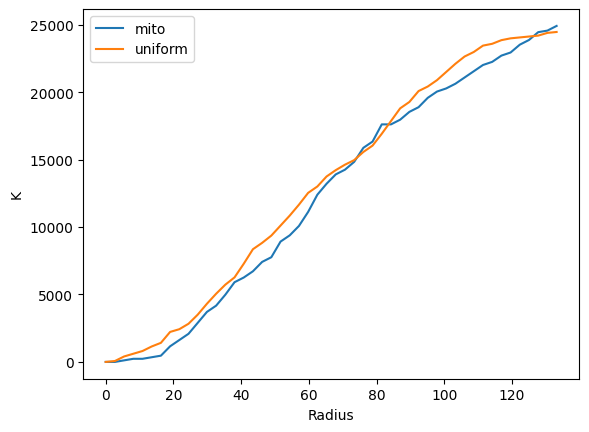

In [ ]:
plt.plot(radii, kt_mito, label='mito')
plt.plot(radii, kt_uniform, label='uniform')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.show()

In [ ]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "mito_data")
result_dir = os.path.join(current_dir, "mito_result")

for file_name in os.listdir(data_dir):
    if file_name.endswith(".mat"):
        file_path = os.path.join(data_dir, file_name)
        mito = readmitodata(file_path)
        vertices = np.array(mito['vertices'], dtype=np.float64)
        faces = np.array(mito['faces'], dtype=np.int32)
        cj = np.array(mito['cristae_junction'], dtype=np.float64)
        points = cj.T
        points = points[:, [1, 0, 2]].astype(np.float64)
        rmax = math.sqrt(rk.mesh_area(vertices, faces) / 2)
        radii = np.linspace(0, rmax, 50)
        if cj.size:
            print(file_name)
            kt_mito = rk.ripleyK_mesh(vertices, faces, points, radii)
            data = np.column_stack((radii, kt_mito))
            result_path = os.path.join(result_dir, os.path.splitext(file_name)[0] + ".csv")
            np.savetxt(result_path, data, delimiter=",", header='radii,kt_mito')
            print(file_name + " result saved")
        else:
            print("No cristae junctions found")

No cristae junctions found
mito_data002.mat
samples [[ 4.50166667 16.49833333 16.50166667]
 [ 1.505      13.         28.        ]
 [ 8.16833333 21.83166667 18.16833333]
 [ 7.7525     25.2475     29.        ]
 [ 7.50166667 26.49833333 31.50166667]
 [18.165      18.165      37.165     ]]
mito_data002.mat result saved
No cristae junctions found
No cristae junctions found
mito_data007.mat
samples [[ 19.50166667  60.49833333  76.50166667]
 [ 16.2525      44.          64.2525    ]
 [ 11.          60.2475      77.7525    ]
 [ 28.835       46.165       56.835     ]
 [ 18.          61.7475      78.2525    ]
 [ 19.2525      33.          62.2525    ]
 [ 18.59852212  23.83126845  79.        ]
 [ 23.7525      16.7525      88.        ]
 [ 25.835       24.835      105.165     ]
 [ 27.2525      14.2525      76.        ]
 [ 33.          59.2475      73.7525    ]
 [ 38.16833333  12.16833333  91.83166667]
 [ 50.7475      39.         105.7475    ]
 [ 48.          19.7525     101.2475    ]
 [ 56.83166667  

KeyboardInterrupt: 